Please download the following zip file, extract it and put it under your google 
drive
https://drive.google.com/open?id=1freMDsM-8AWjmeRVP3iQZ_04Hs1gy8yi

In this example, we will perform a binary classification for heavy makeup and no-heavy makeup images coming from CelebA.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# if you mount Google drive correctly, the following commands should be able to executed correctly
!ls /content/drive/
%cd "/content/drive/My Drive"
% cd "heavy_makeup_CelebA"

!ls

'My Drive'  'Shared drives'
/content/drive/My Drive
/content/drive/My Drive/heavy_makeup_CelebA
train  val


In [0]:
# step 1: preparing HOG feature vectors for heavy makeup & no-heavy makeup classification in training & validation, respectively

from skimage import data, color, feature
import skimage.data
import cv2
from google.colab.patches import cv2_imshow
import glob
import numpy as np
from timeit import default_timer as timer

# image size before cropping
resize_img_w = 256
resize_img_h = 256

# image size after cropping
crop_img_w = 224
crop_img_h = 224

# feature size for 224x224 image using default HOG settings from sklearn
HOG_dim = 54756

# the folder of training data in YOUR Google drive
training_heavy_makeup_imgs_dir = "/content/drive/My Drive/heavy_makeup_CelebA/train/heavy_makeup/"
training_non_heavy_makeup_imgs_dir = "/content/drive/My Drive/heavy_makeup_CelebA/train/no_heavy_makeup/"

# the folder of validation data in YOUR Google drive
validation_heavy_makeup_imgs_dir = "/content/drive/My Drive/heavy_makeup_CelebA/val/heavy_makeup/"
validation_non_heavy_makeup_imgs_dir = "/content/drive/My Drive/heavy_makeup_CelebA/val/no_heavy_makeup/"

# the file lists of training data
training_heavy_makeup_img_files = glob.glob(training_heavy_makeup_imgs_dir + '*.jpg')
training_no_heavy_makeup_img_files = glob.glob(training_non_heavy_makeup_imgs_dir + '*.jpg')

# the file lists of validation data
validation_heavy_makeup_img_files = glob.glob(validation_heavy_makeup_imgs_dir + '*.jpg')
validation_no_heavy_makeup_img_files = glob.glob(validation_non_heavy_makeup_imgs_dir + '*.jpg')

# the number of trainimg images: 1000 for postive and negative, respectively
training_heavy_makeup_img_file_num = len(training_heavy_makeup_img_files)
training_no_heavy_makeup_img_file_num = len(training_no_heavy_makeup_img_files)

# the number of validation images: 1000 for postive and negative, respectively
validation_heavy_makeup_img_file_num = len(validation_heavy_makeup_img_files)
validation_no_heavy_makeup_img_file_num = len(validation_no_heavy_makeup_img_files)


#print(training_heavy_makeup_img_files)
#print(training_no_heavy_makeup_img_files)
#print(validation_heavy_makeup_img_files)
#print(validation_no_heavy_makeup_img_files)

print("the number of heavy makeup images in training folder: ".format(training_heavy_makeup_img_file_num))
print("the number of no heavy makeup images in training folder: ".format(training_no_heavy_makeup_img_file_num))

print("the number of heavy makeup images in validation folder: ".format(validation_heavy_makeup_img_file_num))
print("the number of no heavy makeup images in validation folder: ".format(validation_no_heavy_makeup_img_file_num))

def img_crop(img, resize_img_w, resize_img_h, target_img_w, target_img_h):
  #h, w, c =img.shape
  img = cv2.resize(img, (int(resize_img_w), int(resize_img_h)))  
  top_y = (resize_img_h-target_img_h)/2
  btm_y = resize_img_h-(resize_img_h-target_img_h)/2
  left_x = (resize_img_w-target_img_w)/2
  right_x = resize_img_w-(resize_img_w-target_img_w)/2
  cropped_img = img[int(top_y):int(btm_y),int(left_x):int(right_x) ]
  
  return cropped_img

HOG_postitive_matrix = np.zeros([int(training_heavy_makeup_img_file_num), HOG_dim])
HOG_negative_matrix = np.zeros([int(training_no_heavy_makeup_img_file_num), HOG_dim])

print("start to prepare HOG features for postive training images")
start = timer()
for i in range(0,int(training_heavy_makeup_img_file_num)):
  #print("i={}".format(i))
  img = cv2.imread(training_heavy_makeup_img_files[i])
  img_cropped = img_crop(img, resize_img_w, resize_img_h, crop_img_w, crop_img_h)
  image = cv2.cvtColor(img_cropped, cv2.COLOR_BGR2GRAY)
  hog_vec = feature.hog(image)
  #print(hog_vec.shape)
  HOG_postitive_matrix[i,:] = hog_vec
end = timer()
print("finish preparing HOG features for postive training images and totally {}-seconds are consumed".format(end-start))


print("start to prepare HOG features for negative training images")
start = timer()
for i in range(0,int(training_no_heavy_makeup_img_file_num)):
  #print("i={}".format(i))
  img = cv2.imread(training_no_heavy_makeup_img_files[i])
  img_cropped = img_crop(img, resize_img_w, resize_img_h, crop_img_w, crop_img_h)
  image = cv2.cvtColor(img_cropped, cv2.COLOR_BGR2GRAY)
  hog_vec = feature.hog(image)
  #print(hog_vec.shape)
  HOG_negative_matrix[i,:] = hog_vec
end = timer()
print("finish preparing HOG features for negative training images and totally {}-seconds are consumed".format(end-start))

# stack HOG postive & negative features vertically
training_matrix = np.vstack((HOG_postitive_matrix,HOG_negative_matrix))

# initialize the label matrix where top half is positive
label_matrix = np.zeros(int(training_heavy_makeup_img_file_num) + int(training_no_heavy_makeup_img_file_num))
label_matrix[0:int(training_heavy_makeup_img_file_num)] = 1


1000
1000
200
200
start to prepare HOG features for postive training images
finish preparing HOG features for postive training images and totally 184.84859539799982-seconds are consumed
start to prepare HOG features for negative training images
finish preparing HOG features for negative training images and totally 177.30751888000032-seconds are consumed


In [0]:
# step 2: performing (SVM) classifier training using sklearn

from sklearn.svm import LinearSVC
#from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import GridSearchCV

print("start to perform training")
start = timer()
# brute-force for all hyper parameters in training SVM
grid = GridSearchCV(LinearSVC(), {'C': [1.0, 2.0, 4.0, 8.0]})
grid.fit(training_matrix, label_matrix)
grid.best_score_
model = grid.best_estimator_
model.fit(training_matrix, label_matrix)
end = timer()
print("training is done and totally {}-seconds are consumed".format(end-start))

start to perform training
training is done and totally 312.83456748799927-seconds are consumed


In [0]:
# step 3: accuracy estimation by classifying all the images in the validation folder

# for positive validation data
TP_num = 0
for i in range(0,validation_heavy_makeup_img_file_num): #
  img = cv2.imread(validation_heavy_makeup_img_files[i])
  img_cropped = img_crop(img, resize_img_w, resize_img_h, crop_img_w, crop_img_h)
  image = cv2.cvtColor(img_cropped, cv2.COLOR_BGR2GRAY)
  hog_vec = feature.hog(image)
  hog_vec = hog_vec.reshape(1,-1)
  labels = model.predict(hog_vec)

  if int(labels[0]) == 1:
      #print("this is TP")
      TP_num = TP_num + 1

print("TP_num={}".format(TP_num))

# for negative validation data
TN_num = 0
for i in range(0,validation_no_heavy_makeup_img_file_num): #
  img = cv2.imread(validation_no_heavy_makeup_img_files[i])
  img_cropped = img_crop(img, resize_img_w, resize_img_h, crop_img_w, crop_img_h)  
  image = cv2.cvtColor(img_cropped, cv2.COLOR_BGR2GRAY)
  hog_vec = feature.hog(image)

  #print(hog_vec.shape)
  hog_vec = hog_vec.reshape(1,-1)
  # perform classification
  labels = model.predict(hog_vec)
  if int(labels[0]) == 0:
    #print("this is TP")
    TN_num = TN_num + 1

print("TN_num={}".format(TN_num))
accuracy = (TP_num+TN_num)/(validation_heavy_makeup_img_file_num + validation_no_heavy_makeup_img_file_num)
print("accuracy={}".format(accuracy))


TP_num=180
TN_num=153
accuracy=0.8325


There is a heavy-makeup person inside


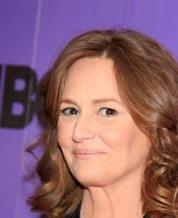

In [0]:
# let's classify an image in the validation set
from google.colab.patches import cv2_imshow

image_i = 0

img = cv2.imread(validation_heavy_makeup_img_files[image_i])
img_cropped = img_crop(img, resize_img_w, resize_img_h, crop_img_w, crop_img_h)
image = cv2.cvtColor(img_cropped, cv2.COLOR_BGR2GRAY)
hog_vec = feature.hog(image)
hog_vec = hog_vec.reshape(1,-1)
labels = model.predict(hog_vec)

if int(labels[0]) == 1:
  print("There is a heavy-makeup person inside")
elif int(labels[0]) == 0:
  print("There is no heavy-makeup person inside")

cv2_imshow(img)